# Begin visualisations

In [97]:
from pathlib import Path
import pandas as pd
import sqlite3
import networkx as nx
#import matplotlib.pyplot as plt
from ipycytoscape import CytoscapeWidget
from sqlite3 import OperationalError
from contextlib import suppress
import ipywidgets as widgets
from pprint import pprint
import py4cytoscape as p4c

In [98]:
working = Path('..')
working

PosixPath('..')

In [99]:
!pwd

/Users/Jon/Developer/Github/dh-trace/notebooks


In [100]:
!ls $working

LICENSE                   hapaxes_1tM.py            make_histogram.py
Project History.pdf       init_db.py                make_jumbo_dash.py
README.md                 load_alignments.py        make_lines.py
__pycache__               load_authors_and_texts.py notebooks
arch                      load_hapax_intersects.py  poetry.lock
authors.txt               load_hapaxes.py           predict_ops.py
auto_author_prediction.py load_jaccard.py           projects
begin.sh                  load_ngram_intersects.py  pyproject.toml
database_ops.py           load_ngrams.py            requirements.txt
dh-trace-venv             load_relationships.py     show_previous_averages.py
diagrams.ipynb            make_3d_plot.py           util.py
do_svm.py                 make_auto_scatterplot.py  utils
do_viz.sh                 make_confusion.py
explore                   make_dash.py


In [101]:
things = working.glob('*')

In [102]:
for thing in things:
    print(thing)

../make_dash.py
../database_ops.py
../diagrams.ipynb
../.DS_Store
../LICENSE
../requirements.txt
../make_lines.py
../util.py
../auto_author_prediction.py
../make_confusion.py
../projects
../pyproject.toml
../predict_ops.py
../load_jaccard.py
../do_viz.sh
../utils
../__pycache__
../load_hapaxes.py
../Project History.pdf
../explore
../README.md
../load_ngram_intersects.py
../load_hapax_intersects.py
../load_ngrams.py
../.gitignore
../arch
../.venv
../load_alignments.py
../make_jumbo_dash.py
../begin.sh
../load_authors_and_texts.py
../hapaxes_1tM.py
../make_auto_scatterplot.py
../show_previous_averages.py
../make_3d_plot.py
../poetry.lock
../.git
../.vscode
../load_relationships.py
../authors.txt
../dh-trace-venv
../make_histogram.py
../notebooks
../do_svm.py
../.current_project
../init_db.py


In [103]:
project_name = 'sm-test'
project_path = working / 'projects' / project_name

In [104]:
project_path

PosixPath('../projects/sm-test')

In [105]:
db_path = project_path / 'db' / f'{project_name}.db'
svm_db_path = project_path / 'db' / 'svm.db'
db_path
svm_db_path

PosixPath('../projects/sm-test/db/svm.db')

In [106]:
db_path.exists()

True

In [107]:
# Define the EDGES_QUERY template with placeholders for weight_id and threshold
EDGES_QUERY_TEMPLATE = """
WITH RankedResults AS (
    SELECT 
        calculation.pair_id,
        round(calculation.comp_score, 3) as comp_score,
        calculation.threshold,
        weight.weight_id,
        weight.hap_weight,
        weight.al_weight,
        weight.svm_weight,
        combined_jaccard.hap_jac_dis,
        combined_jaccard.hap_jac_sim,
        combined_jaccard.al_jac_dis,
        combined_jaccard.al_jac_sim,
        text_pair.text_a AS a_text_id,
        text_pair.text_b AS b_text_id,
        text_a.source_filename AS a_text_filename,
        text_b.source_filename AS b_text_filename,
        text_a.chapter_num AS a_chap_num,
        text_b.chapter_num AS b_chap_num,
        dir_a.id AS a_work_dir_id,
        dir_b.id AS b_work_dir_id,
        dir_a.dir AS a_work,
        dir_b.dir AS b_work,
        text_a.author_id AS a_author_id,
        text_b.author_id AS b_author_id,
        text_a.short_name_for_svm AS a_short,
        text_b.short_name_for_svm AS b_short,
        calculation.same_author,
        author_a.author_name AS a_author,
        author_b.author_name AS b_author,
        ROW_NUMBER() OVER (PARTITION BY weight.weight_id, calculation.threshold ORDER BY calculation.pair_id) as row_num
    FROM calculations AS calculation
        JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id
        JOIN weights AS weight ON weight.weight_id = calculation.weight_id
        JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a
        JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b
        JOIN dirs AS dir_a ON dir_a.id = text_a.dir
        JOIN dirs AS dir_b ON dir_b.id = text_b.dir
        JOIN authors AS author_a ON author_a.id = text_a.author_id
        JOIN authors AS author_b ON author_b.id = text_b.author_id
        JOIN combined_jaccard ON combined_jaccard.pair_id = calculation.pair_id
    WHERE weight.weight_id = {weight_id}
    AND calculation.threshold = {threshold}
    AND dir_a.id <> dir_b.id
    LIMIT 100
)
SELECT *
FROM RankedResults
ORDER BY weight_id, pair_id
"""
#add LIMIT 100 at bottom to limit results to first 100

In [108]:
EDGES_QUERY_TEMPLATE

'\nWITH RankedResults AS (\n    SELECT \n        calculation.pair_id,\n        round(calculation.comp_score, 3) as comp_score,\n        calculation.threshold,\n        weight.weight_id,\n        weight.hap_weight,\n        weight.al_weight,\n        weight.svm_weight,\n        combined_jaccard.hap_jac_dis,\n        combined_jaccard.hap_jac_sim,\n        combined_jaccard.al_jac_dis,\n        combined_jaccard.al_jac_sim,\n        text_pair.text_a AS a_text_id,\n        text_pair.text_b AS b_text_id,\n        text_a.source_filename AS a_text_filename,\n        text_b.source_filename AS b_text_filename,\n        text_a.chapter_num AS a_chap_num,\n        text_b.chapter_num AS b_chap_num,\n        dir_a.id AS a_work_dir_id,\n        dir_b.id AS b_work_dir_id,\n        dir_a.dir AS a_work,\n        dir_b.dir AS b_work,\n        text_a.author_id AS a_author_id,\n        text_b.author_id AS b_author_id,\n        text_a.short_name_for_svm AS a_short,\n        text_b.short_name_for_svm AS b_shor

In [109]:
con = sqlite3.connect(db_path)

In [110]:
#creates a view of the extensive query above and lets me work with it as if it's a tables

# Fetch unique weight_ids from the database
weight_ids_query = "SELECT DISTINCT weight_id FROM weights"
weight_ids_df = pd.read_sql(weight_ids_query, con)
weight_ids = weight_ids_df['weight_id'].tolist()

# Fetch unique thresholds from the database
thresholds_query = "SELECT DISTINCT threshold FROM calculations"
thresholds_df = pd.read_sql(thresholds_query, con)
thresholds = thresholds_df['threshold'].tolist()

i = 0
con.execute("DROP TABLE IF EXISTS edges")
con.execute("DROP VIEW IF EXISTS edges")
con.execute("BEGIN TRANSACTION")
for weight_id in weight_ids:
    for threshold in thresholds:
        # Format the query with the current weight_id and threshold
        formatted_query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
        
        if i < 1:
            # Create the initial view
            create_view_query = f"CREATE TEMP TABLE edges AS {formatted_query}"
            with suppress(sqlite3.OperationalError):
                con.execute(create_view_query)
            i += 1
        else:
            append_view_query = f"INSERT INTO edges SELECT * FROM ({formatted_query})"
            con.execute(append_view_query)
            #TODO - check suppression of errors

con.commit()

In [111]:
all_results = []
for weight_id in weight_ids:
    for threshold in thresholds:
        # Format the query with the current weight_id and threshold
        query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
        
        # Execute the query and fetch results
        results = pd.read_sql(query, con)
        
        # Add results to the list
        all_results.append(results)

# Combine all results into a single DataFrame
edges_df = pd.concat(all_results, ignore_index=True)

In [112]:
svm_con = sqlite3.connect(svm_db_path)

def get_svm_score(a_short, a_chap_num, b_short):
    query = f"""
    SELECT {b_short} AS svm_score
    FROM chapter_assessments
    WHERE novel = ?
    AND number = ?
    """
    
    result = pd.read_sql(query, svm_con, params=(a_short, a_chap_num))
    
    if not result.empty:
        return result['svm_score'].iloc[0]
    return None

# Apply the function to each row in edges_df
edges_df['svm_score'] = edges_df.apply(lambda row: get_svm_score(row['a_short'], row['a_chap_num'], row['b_short']), axis=1)

# Close the connection to svm.db
svm_con.close()

In [128]:
#edges_df = pd.read_sql(df_query, con)
print(f"{len(edges_df):,}")
print(edges_df.sample(n=100, random_state=42))
columns_list = edges_df.columns.tolist()
print(columns_list)

1,000
       pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
1315      1093       0.887       0.85          1       0.150      0.700   
10068     2508       0.866       0.80         12       0.250      0.500   
15905      423       0.666       0.95         19       0.300      0.300   
17369     2545       0.746       0.85         21       0.325      0.325   
1738      1594       0.893       0.65          2       0.700      0.150   
...        ...         ...        ...        ...         ...        ...   
12944     1675       0.782       0.65         16       0.450      0.275   
13455     2120       0.847       0.90         16       0.450      0.275   
13749     1740       0.627       0.65         17       0.275      0.275   
14202      111       0.678       0.90         17       0.275      0.275   
19094     3002       0.757       0.90         23       0.325      0.350   

       svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  al_jac_sim  \
1315        0.150     

In [129]:
# NOTE: This is just here so we can see all the columns. Delete when sure it works.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(edges_df)

,pair_id,comp_score,threshold,weight_id,hap_weight,al_weight,svm_weight,hap_jac_dis,hap_jac_sim,al_jac_dis,al_jac_sim,a_text_id,b_text_id,a_text_filename,b_text_filename,a_chap_num,b_chap_num,a_work_dir_id,b_work_dir_id,a_work,b_work,a_author_id,b_author_id,a_short,b_short,same_author,a_author,b_author,row_num,svm_score
13188,2939,0.752,0.75,16,0.450,0.275,0.275,0.930257,0.069743,0.998180,0.001820,574,391,1840-ENG18400—Trollope-chapter_13,1847-ENG18471—Bronte-chapter_8,13,8,9,5,1840-ENG18400—Trollope,1847-ENG18471—Bronte,9,5,ENG18400—Trollope,ENG18471—Bronte,False Positive,Trollope,Brontë,89,0.104563
15320,1387,0.712,0.65,19,0.300,0.300,0.400,0.943275,0.056725,0.999160,0.000840,593,249,1840-ENG18400—Trollope-chapter_11,1846-ENG18460—Reynolds-chapter_133,11,133,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,False Positive,Trollope,Reynolds,21,0.891420
18388,2939,0.720,0.95,22,0.350,0.325,0.325,0.930257,0.069743,0.998180,0.001820,574,391,1840-ENG18400—Trollope-chapter_13,1847-ENG18471—Bronte-chapter_8,13,8,9,5,1840-ENG18400—Trollope,1847-ENG18471—Bronte,9,5,ENG18400—Trollope,ENG18471—Bronte,No,Trollope,Brontë,89,0.104563
2998,3074,0.545,0.85,3,0.175,0.175,0.650,0.936057,0.063943,0.999212,0.000788,574,510,1840-ENG18400—Trollope-chapter_13,1853-ENG18531—Yonge-chapter_4,13,4,9,7,1840-ENG18400—Trollope,1853-ENG18531—Yonge,9,7,ENG18400—Trollope,ENG18531—Yonge,No,Trollope,Yonge,99,0.000000
3899,3078,0.867,0.90,4,0.175,0.650,0.175,0.926745,0.073255,0.999379,0.000621,574,526,1840-ENG18400—Trollope-chapter_13,1853-ENG18531—Yonge-chapter_43,13,43,9,7,1840-ENG18400—Trollope,1853-ENG18531—Yonge,9,7,ENG18400—Trollope,ENG18531—Yonge,No,Trollope,Yonge,100,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13541,1649,0.839,0.95,16,0.450,0.275,0.275,0.929775,0.070225,0.999254,0.000746,593,640,1840-ENG18400—Trollope-chapter_11,1848-ENG18481—Dickens-chapter_27,11,27,9,10,1840-ENG18400—Trollope,1848-ENG18481—Dickens,9,10,ENG18400—Trollope,ENG18481—Dickens,No,Trollope,Dickens,42,0.777295
16530,1521,0.805,0.85,20,0.400,0.300,0.300,0.942237,0.057763,0.998949,0.001051,593,47,1840-ENG18400—Trollope-chapter_11,1846-ENG18460—Reynolds-chapter_254,11,254,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,31,0.891420
14957,2221,0.842,0.85,18,0.300,0.400,0.300,0.943060,0.056940,0.998649,0.001351,577,93,1840-ENG18400—Trollope-chapter_12,1846-ENG18460—Reynolds-chapter_59,12,59,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,58,0.892021
9749,1740,0.786,0.65,12,0.250,0.500,0.250,0.933640,0.066360,0.999079,0.000921,593,530,1840-ENG18400—Trollope-chapter_11,1853-ENG18531—Yonge-chapter_19,11,19,9,7,1840-ENG18400—Trollope,1853-ENG18531—Yonge,9,7,ENG18400—Trollope,ENG18531—Yonge,False Positive,Trollope,Yonge,50,0.210777


In [114]:
# SOLVED A way to choose whether to exclude a piece of a work from connecting to itself (e.g. Trollope 1840 ch 10, ibid ch 20) (solved in SQL)

#A way to visibly toggle the thresholds to fine-grainedly shade edges and possibly connect them closer

#A way to only display desired authors all the way down to one
#A way to visibly toggle the weights
#A way to light up nodes above a certain threshold even if lower thresholds are displayed
#use pandas to group by work so individual book can be displayed on the graph below. 

edges_df = edges_df.sample(1000)
print(len(edges_df))
min_comp_score = edges_df['comp_score'].min() 
max_comp_score = edges_df['comp_score'].max() 
print(min_comp_score, max_comp_score)

1000
0.438 0.922


In [115]:
G = nx.from_pandas_edgelist(
    edges_df,
    source = 'a_text_filename',
    target = 'b_text_filename',
    edge_attr = ['comp_score'],
    create_using = nx.DiGraph)
                            
                            

In [127]:
print(edges_df.sample(n=10))

       pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
11667     2503       0.856       0.80         14       0.500       0.25   
16628     1508       0.804       0.90         20       0.400       0.30   
11471     2591       0.801       0.70         14       0.500       0.25   
12316     1105       0.795       0.75         15       0.275       0.45   
21104      353       0.837       0.75         26       0.350       0.35   
20745     1684       0.818       0.95         25       0.300       0.35   
3341      1649       0.905       0.65          4       0.175       0.65   
21185     2808       0.777       0.75         26       0.350       0.35   
16571     2591       0.772       0.85         20       0.400       0.30   
20029     1520       0.822       0.60         25       0.300       0.35   

       svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  al_jac_sim  \
11667       0.250     0.948784     0.051216    0.998369    0.001631   
16628       0.300     0.941290  

In [117]:
G

In [118]:
TEXT_FONT_SIZE = 8

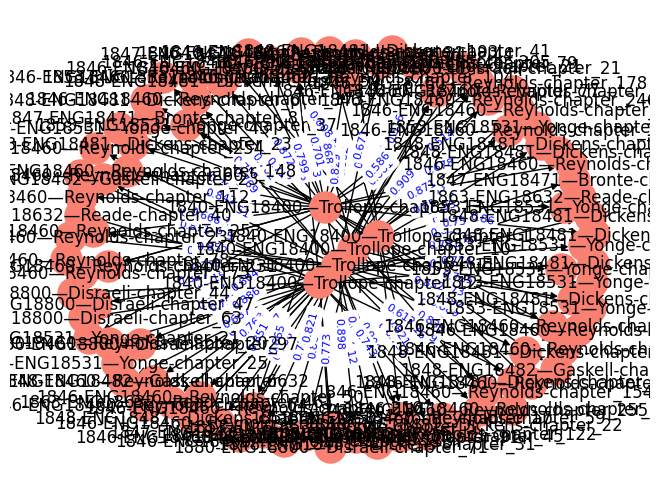

In [119]:
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

 # Draw nodes with labels
nx.draw(G, width=1, node_size=500, node_color='salmon', with_labels=True)
# Draw edges with arrows and labels
edge_labels = nx.get_edge_attributes(G, 'comp_score')
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=TEXT_FONT_SIZE)


In [120]:
C = CytoscapeWidget()
#C.set_layout(name='cola')
C.set_layout(name='dagre', rankDir='LR', spacingFactor=3)
C.graph.add_graph_from_networkx(G, directed=True)


In [121]:
#this is so we can programmatically edit and choose variables for the graph

def build_style(color_threshold):
    return [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'salmon',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'label': 'data(id)'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': 'black',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'color': 'blue',
                 'label': 'data(comp_score)',
                'width': f"mapData(comp_score, {min_comp_score}, {max_comp_score}, 1, 10)"
                 #'width': '10px',
             }
        },
        {
            "selector": "edge.directed",
            "style": {
                "curve-style": "bezier",
                "target-arrow-shape": "triangle",
                "target-arrow-color": "black",
            }
        }, 
        {
            "selector": f"edge[comp_score>{color_threshold}]",
            "style": {
                "line-color": "red",
            }
        },
    ]
style = build_style(0.92)
pprint(style)
C.set_style(style)

[{'selector': 'node',
  'style': {'background-color': 'salmon',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(id)'}},
 {'selector': 'edge',
  'style': {'color': 'blue',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(comp_score)',
            'line-color': 'black',
            'width': 'mapData(comp_score, 0.438, 0.922, 1, 10)'}},
 {'selector': 'edge.directed',
  'style': {'curve-style': 'bezier',
            'target-arrow-color': 'black',
            'target-arrow-shape': 'triangle'}},
 {'selector': 'edge[comp_score>0.92]', 'style': {'line-color': 'red'}}]


In [122]:
#make slider

caption = widgets.Label(value='The slider value is in its initial position.')

slider = widgets.IntSlider(
    value=90,
    min=90,
    max=100,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def handle_slider_change(change):
    color_threshold = change.new / 100
    caption.value = f"The slider value is: {color_threshold}"
    style = build_style(color_threshold=color_threshold)
    C.set_style(style)
    
slider.observe(handle_slider_change, names='value')
display(caption, slider)

Label(value='The slider value is in its initial position.')

IntSlider(value=90, continuous_update=False, description='Test:', min=90)

In [123]:
C

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'LR', 'spacingFactor': 3}, cytoscape_style=[{'se…

 # MOVE OVER TO CYTOSCAPE APP FOR STRETCHY THINGS

 ## todo

 1. annotate edges in dataset
 2. regenerate all data
 3. deal with SVMs
 4. document and lock sequence alignment version
 5. fully remove and document removal of n-grams
 7. display more easy to see
 8. full dataset
 9. moving to dissertation; initial check against tarah's dataset
 10. do full relevant close re-reading
 11. 

In [124]:
p4c.cytoscape_ping()

In cyrest_get: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.


RequestException: Cannot find local or remote Cytoscape. Start Cytoscape and then proceed.

In [ ]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.2',
 'automationAPIVersion': '1.9.0',
 'py4cytoscapeVersion': '1.9.0'}

In [ ]:
p4c.create_network_from_networkx(G)


Applying default style...
Applying preferred layout


116090